/var/folders/q8/vdt2vm_57wvdf70tmml2yjy40000gn/T/ipykernel_66593/1370346326.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
2025-05-27 12:43:39,585	INFO worker.py:1718 -- Calling ray.init() again after it has already been called.
2025-05-27 12:43:39,588	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/3694

== Status ==
Current time: 2025-05-27 12:43:39 (running for 00:00:00.15)
Using FIFO scheduling algorithm.
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-05-27_12-26-37_913691_66593/artifacts/2025-05-27_12-43-39/train_rf_2025-05-27_12-43-39/driver_artifacts
Number of trials: 10/10 (10 PENDING)




Trial name,r2_score
train_rf_735e6_00000,0.642956
train_rf_735e6_00001,0.645586
train_rf_735e6_00002,0.647628
train_rf_735e6_00003,0.647628
train_rf_735e6_00004,0.645948
train_rf_735e6_00005,0.643059
train_rf_735e6_00006,0.640332
train_rf_735e6_00007,0.640641
train_rf_735e6_00008,0.649043
train_rf_735e6_00009,0.645586


== Status ==
Current time: 2025-05-27 12:43:44 (running for 00:00:05.21)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Current best trial: 735e6_00002 with r2_score=0.6476276663080069 and parameters={'n_estimators': 250, 'max_depth': 5, 'min_samples_split': 8}
Result logdir: /tmp/ray/session_2025-05-27_12-26-37_913691_66593/artifacts/2025-05-27_12-43-39/train_rf_2025-05-27_12-43-39/driver_artifacts
Number of trials: 10/10 (2 PENDING, 8 TERMINATED)




2025-05-27 12:43:45,397	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/sparshpaliya/ray_results/train_rf_2025-05-27_12-43-39' in 0.0055s.
2025-05-27 12:43:45,398	INFO tune.py:1041 -- Total run time: 5.81 seconds (5.80 seconds for the tuning loop).


== Status ==
Current time: 2025-05-27 12:43:45 (running for 00:00:05.81)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Current best trial: 735e6_00008 with r2_score=0.6490427504232918 and parameters={'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 8}
Result logdir: /tmp/ray/session_2025-05-27_12-26-37_913691_66593/artifacts/2025-05-27_12-43-39/train_rf_2025-05-27_12-43-39/driver_artifacts
Number of trials: 10/10 (10 TERMINATED)
+----------------------+------------+-----------------+-------------+---------------------+----------------+------------+
| Trial name           | status     | loc             |   max_depth |   min_samples_split |   n_estimators |   r2_score |
|----------------------+------------+-----------------+-------------+---------------------+----------------+------------|
| train_rf_735e6_00000 | TERMINATED | 127.0.0.1:68066 |          20 |                   6 |            200 |   0.642956 |
| train_rf_735e6_00001 | TERMINATED | 

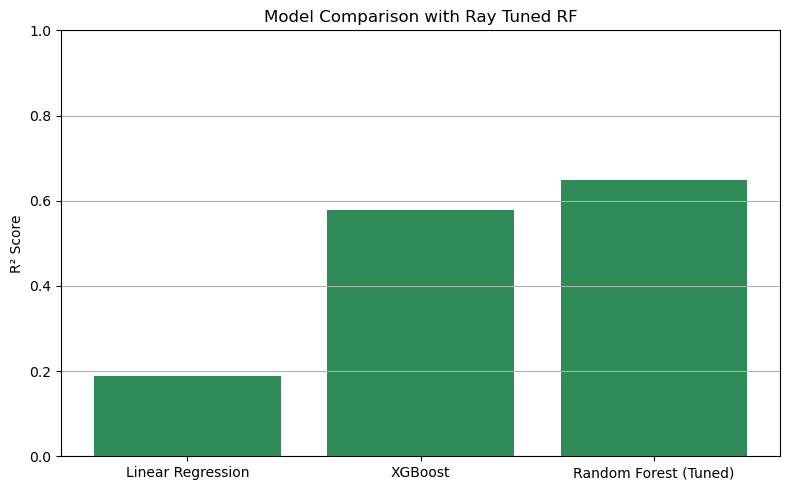

In [24]:
import paramiko
import pandas as pd
import numpy as np
from io import StringIO
import sys
import joblib
import ray
from ray import tune
from ray.tune import CLIReporter, with_parameters
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ================
# VM CONNECTION
# ================
CLIENT_IP = '130.238.28.161'
USERNAME = 'ubuntu'
KEY_FILE = '/Users/sparshpaliya/Downloads/PRJ_Group13.pem'
REMOTE_PATH = '/home/ubuntu/DE2-group-13-project/Development/scraping/repo_data.csv'

def fetch_csv_via_ssh():
    try:
        ssh = paramiko.SSHClient()
        ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh.connect(CLIENT_IP, username=USERNAME, key_filename=KEY_FILE)
        sftp = ssh.open_sftp()
        with sftp.open(REMOTE_PATH) as f:
            content = f.read().decode()
        sftp.close()
        ssh.close()
        return pd.read_csv(StringIO(content))
    except Exception as e:
        print(f"Failed to fetch dataset: {e}", file=sys.stderr)
        sys.exit(1)

# ================
# DATA PREP
# ================
data = fetch_csv_via_ssh()
drop_cols = ['watchers_count', 'full_name', 'description', 'created_at', 'updated_at', 'language']
data.drop(columns=[c for c in drop_cols if c in data.columns], inplace=True)
data['forks_to_size_ratio'] = data['forks_count'] / data['size'].replace(0, 1)
data['open_issues_per_fork'] = data['open_issues_count'] / (data['forks_count'] + 1)
data['is_active'] = (~data['archived']).astype(int)

for col in data.select_dtypes(include=[np.number]).columns:
    data[col].fillna(data[col].median(), inplace=True)

target = 'stargazers_count'
X = data.drop(columns=[target])
y = data[target]

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ================
# RAY TUNE TRAINABLE
# ================
def train_rf(config, X_train, X_val, y_train, y_val, numeric_cols, categorical_cols):
    try:
        preprocessor = ColumnTransformer([
            ('num', 'passthrough', numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ])
        rf = RandomForestRegressor(
            n_estimators=config["n_estimators"],
            max_depth=config["max_depth"],
            min_samples_split=config["min_samples_split"],
            random_state=42,
            n_jobs=1
        )
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("regressor", rf)
        ])
        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_val)
        r2 = r2_score(y_val, preds)
        tune.report({"r2_score": r2})  # ✅ works across Ray versions
    except Exception as e:
        tune.report({"r2_score": -1.0})
        print(f"[ERROR] Trial failed: {e}", file=sys.stderr)

# ================
# RAY TUNE RUN
# ================
ray.init(ignore_reinit_error=True)

search_space = {
    "n_estimators": tune.choice([100, 150, 200, 250]),
    "max_depth": tune.choice([5, 10, 15, 20]),
    "min_samples_split": tune.choice([2, 4, 6, 8])
}

trainable = with_parameters(
    train_rf,
    X_train=X_train,
    X_val=X_val,
    y_train=y_train,
    y_val=y_val,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols
)

analysis = tune.run(
    trainable,
    config=search_space,
    metric="r2_score",
    mode="max",
    num_samples=10,
    resources_per_trial={"cpu": 1},
    progress_reporter=CLIReporter(metric_columns=["r2_score"]),
    fail_fast=False
)

best_config = analysis.best_config
print(f"\n✅ Best hyperparameters from Ray Tune: {best_config}")

# ================
# FINAL MODEL COMPARISON
# ================
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

best_rf = RandomForestRegressor(**best_config, random_state=42, n_jobs=-1)

models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "Random Forest (Tuned)": best_rf
}

results = []
best_model = None
best_score = -np.inf

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_val)
    r2 = r2_score(y_val, preds)

    results.append({
        "Model": name,
        "MSE": mean_squared_error(y_val, preds),
        "MAE": mean_absolute_error(y_val, preds),
        "R2": r2
    })

    if r2 > best_score:
        best_score = r2
        best_model = pipeline

joblib.dump(best_model, "new_model.pkl")

# ================
# OUTPUT & PLOT
# ================
print("\nModel Evaluation Results:")
for r in results:
    print(f"{r['Model']}: R2 = {r['R2']:.4f}, MSE = {r['MSE']:.2f}, MAE = {r['MAE']:.2f}")
print("\n✅ Best model saved as: new_model.pkl")

plt.figure(figsize=(8, 5))
plt.bar([r['Model'] for r in results], [r['R2'] for r in results], color='seagreen')
plt.ylabel("R² Score")
plt.title("Model Comparison with Ray Tuned RF")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

ray.shutdown()
